In [2]:
import numpy as np
import pandas as pd
import librosa.display
import matplotlib.pyplot as plt

import xgboost as xgb
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features.csv")
df.drop(["Unnamed: 0"], axis=1, inplace=True)
df["patient_id"] = df["patient_id"].astype("int")
df["lead_id"] = df["lead_id"].astype("int")

In [7]:
df.head(5)

,patient_id,lead_id,pr_ratio,rr_distance,p_energy,t_energy,pq_distance,qt_interval,st_slope,pr_slope,qrs_energy,rsq,heart_rate,edr_time_ratio,edr_energy_ratio
0,0,1,-0.054317,377.083333,-3297.249202,5756.845777,57.000000,0.404318,3.122865,8.642640,8564.971669,913.046274,0.159116,1.007608,1.011732
1,0,2,0.173118,377.166667,9.640745,2769.939236,57.692308,0.441143,1.907872,2.284969,1435.067840,444.574330,0.159081,0.876788,0.744761
2,0,3,0.803948,411.090909,3226.989388,861.597898,46.833333,0.373397,5.337444,0.085836,-1520.994131,447.789323,0.145953,0.959859,0.946903
3,0,4,0.763358,383.000000,2931.324322,2988.418158,66.461538,0.271741,8.208612,0.346546,48.321557,401.243304,0.156658,1.140411,1.100461
4,0,5,-0.058833,411.272727,-3019.002055,4359.392590,43.916667,0.360466,2.422612,9.218017,8780.695173,786.025130,0.145889,1.045801,0.947137


In [8]:
5# we have 2164 patients
# 20% of 2164 is approximately equals to 433 patients
# randomly generating 433 patients
import random
all_patients = list(range(0, 2164))
selected_patients = random.sample(all_patients, 433)

In [9]:
folder_path = "/content/drive/MyDrive/DIS_Dr_Liu/"
small_X_path = folder_path + "small_X.npy"
small_y_path = folder_path + "small_y.npy"
ecg_X = np.load(small_X_path, allow_pickle=True)
ecg_y = np.load(small_y_path, allow_pickle=True)

print('X: ', ecg_X.shape)
print('y: ', ecg_y.shape)

print(ecg_X[0])
print(ecg_y[0])

X:  (2164, 12, 5000)
y:  (2164,)
[[  10   15   -5 ... -107  -88  -39]
 [ -20   -5  -20 ... -122 -112  -63]
 [ -30  -20  -15 ...  -15  -24  -24]
 ...
 [  34   29   49 ...  137  127   83]
 [ -29  -34  -10 ...   83   73   20]
 [ -39  -59  -34 ...  142  122   39]]
1


In [10]:
y = ecg_y
target_df = pd.DataFrame()
target_df["patient_id"] = all_patients
target_df["target"] = y
target_df["patient_id"] = target_df["patient_id"].astype("int")
target_df["target"] = target_df["target"].astype("int")

In [11]:
merged_df = pd.merge(df, target_df, on='patient_id', how='inner')

In [12]:
merged_df.isna().sum()

patient_id             0
lead_id                0
pr_ratio             520
rr_distance          474
p_energy             520
t_energy             520
pq_distance          520
qt_interval          994
st_slope             520
pr_slope             520
qrs_energy           520
rsq                  520
heart_rate           994
edr_time_ratio      2936
edr_energy_ratio    2936
target                 0
dtype: int64

In [13]:
merged_df.dropna(inplace=True)
merged_df

,patient_id,lead_id,pr_ratio,rr_distance,p_energy,t_energy,pq_distance,qt_interval,st_slope,pr_slope,qrs_energy,rsq,heart_rate,edr_time_ratio,edr_energy_ratio,target
0,0,1,-0.054317,377.083333,-3297.249202,5756.845777,57.000000,0.404318,3.122865,8.642640,8564.971669,913.046274,0.159116,1.007608,1.011732,1
1,0,2,0.173118,377.166667,9.640745,2769.939236,57.692308,0.441143,1.907872,2.284969,1435.067840,444.574330,0.159081,0.876788,0.744761,1
2,0,3,0.803948,411.090909,3226.989388,861.597898,46.833333,0.373397,5.337444,0.085836,-1520.994131,447.789323,0.145953,0.959859,0.946903,1
3,0,4,0.763358,383.000000,2931.324322,2988.418158,66.461538,0.271741,8.208612,0.346546,48.321557,401.243304,0.156658,1.140411,1.100461,1
4,0,5,-0.058833,411.272727,-3019.002055,4359.392590,43.916667,0.360466,2.422612,9.218017,8780.695173,786.025130,0.145889,1.045801,0.947137,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,2163,8,0.488058,455.800000,162.286435,2295.213058,67.909091,0.162152,5.545811,0.418477,-4305.583086,635.646834,0.131637,0.953257,0.937737,0
25964,2163,9,-0.016470,471.625000,-9889.188938,-2982.607416,52.888889,0.537857,-1.348335,3.153742,16201.075260,511.905208,0.127220,1.879499,1.736153,0
25965,2163,10,0.477778,428.800000,-3090.423671,-302.615363,64.272727,0.633480,0.746142,1.198969,12511.021144,368.125365,0.139925,1.033777,1.018536,0
25966,2163,11,-0.089861,428.500000,-2825.421094,10080.342482,52.363636,0.384428,4.580217,7.207576,4125.364610,804.815869,0.140023,1.602314,1.578354,0


In [14]:
merged_df.to_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features_merged.csv")

# Models on all data using Standard Normalization

In [15]:
# merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features.csv")
# merged_df.drop("Unnamed: 0", axis=1, inplace=True)
# merged_df.dropna(inplace=True)

In [16]:
merged_df

,patient_id,lead_id,pr_ratio,rr_distance,p_energy,t_energy,pq_distance,qt_interval,st_slope,pr_slope,qrs_energy,rsq,heart_rate,edr_time_ratio,edr_energy_ratio,target
0,0,1,-0.054317,377.083333,-3297.249202,5756.845777,57.000000,0.404318,3.122865,8.642640,8564.971669,913.046274,0.159116,1.007608,1.011732,1
1,0,2,0.173118,377.166667,9.640745,2769.939236,57.692308,0.441143,1.907872,2.284969,1435.067840,444.574330,0.159081,0.876788,0.744761,1
2,0,3,0.803948,411.090909,3226.989388,861.597898,46.833333,0.373397,5.337444,0.085836,-1520.994131,447.789323,0.145953,0.959859,0.946903,1
3,0,4,0.763358,383.000000,2931.324322,2988.418158,66.461538,0.271741,8.208612,0.346546,48.321557,401.243304,0.156658,1.140411,1.100461,1
4,0,5,-0.058833,411.272727,-3019.002055,4359.392590,43.916667,0.360466,2.422612,9.218017,8780.695173,786.025130,0.145889,1.045801,0.947137,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25963,2163,8,0.488058,455.800000,162.286435,2295.213058,67.909091,0.162152,5.545811,0.418477,-4305.583086,635.646834,0.131637,0.953257,0.937737,0
25964,2163,9,-0.016470,471.625000,-9889.188938,-2982.607416,52.888889,0.537857,-1.348335,3.153742,16201.075260,511.905208,0.127220,1.879499,1.736153,0
25965,2163,10,0.477778,428.800000,-3090.423671,-302.615363,64.272727,0.633480,0.746142,1.198969,12511.021144,368.125365,0.139925,1.033777,1.018536,0
25966,2163,11,-0.089861,428.500000,-2825.421094,10080.342482,52.363636,0.384428,4.580217,7.207576,4125.364610,804.815869,0.140023,1.602314,1.578354,0


In [17]:
merged_df["target"].value_counts()

0    11610
1    11422
Name: target, dtype: int64

In [18]:
# merged_df = merged_df[merged_df["lead_id"] == 1]
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

X = merged_df.drop(["patient_id", "lead_id", "target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,pr_ratio,rr_distance,p_energy,t_energy,pq_distance,qt_interval,st_slope,pr_slope,qrs_energy,rsq,heart_rate,edr_time_ratio,edr_energy_ratio
0,0.044578,0.460673,-0.261895,2.827560,-1.014436,-1.635436,-0.581299,-0.462150,1.478209,-1.826021,-0.631710,0.452027,0.495842
1,-0.033533,-0.362100,0.526806,-0.696861,-1.143141,-0.032647,-0.527787,1.459148,0.841739,0.377754,0.218280,-0.292169,-0.330485
2,-0.064479,-0.341697,-0.457739,0.769086,-0.284283,-0.116754,0.132638,0.995406,0.281767,0.560300,0.193621,-0.279817,-0.263197
3,0.000252,0.503055,0.303271,-0.370805,-1.149576,-0.155184,-0.578224,-0.675718,-0.476814,-1.026502,-0.668691,-0.664228,-0.663593
4,-0.022814,1.077622,0.309961,0.381229,-0.646197,-0.395442,0.269318,-0.217201,-0.679940,0.200776,-1.119668,-0.357000,-0.355496
...,...,...,...,...,...,...,...,...,...,...,...,...,...
23027,-0.053658,-0.441960,-0.106910,0.113784,-0.338735,-0.292595,-0.310727,0.471966,0.359577,-0.105507,0.316893,-0.504201,-0.503680
23028,-0.040731,0.113911,0.079945,0.893902,0.481759,-0.478949,0.459827,0.701567,0.320805,0.718598,-0.306407,0.145259,0.166246
23029,-0.031623,0.582682,1.012208,-0.617249,-1.278281,1.270513,-0.614314,1.259346,1.786563,0.232575,-0.736668,-0.257179,-0.107967
23030,0.010127,1.420050,0.616728,-0.267700,-2.104853,0.147571,-0.653155,-0.794109,-0.662235,-1.445198,-1.350432,0.412080,0.503430


# K-Fold

In [19]:
from sklearn.model_selection import cross_val_score, train_test_split

## Training and Testing on Complete Data

In [20]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [21]:
len(X_train), len(X_test)

(18425, 4607)

In [22]:
y.value_counts()

0    11610
1    11422
Name: target, dtype: int64

## Logistic Regression

In [23]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

Cross-Validation Scores: [0.53595658 0.54464043 0.52374491 0.53839891 0.52238806]
Mean CV Accuracy: 0.5330


In [24]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5307141306707185
F1 Score: 0.49224988257397845
Precision: 0.5355135411343894
Recall: 0.4554541503694046


## Decision Trees

In [26]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.57639077 0.57584803 0.59321574 0.59484396 0.57069199]
Mean CV Accuracy: 0.5822


In [27]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6019101367484263
F1 Score: 0.6000872219799389
Precision: 0.6021881838074398
Recall: 0.5980008691873099


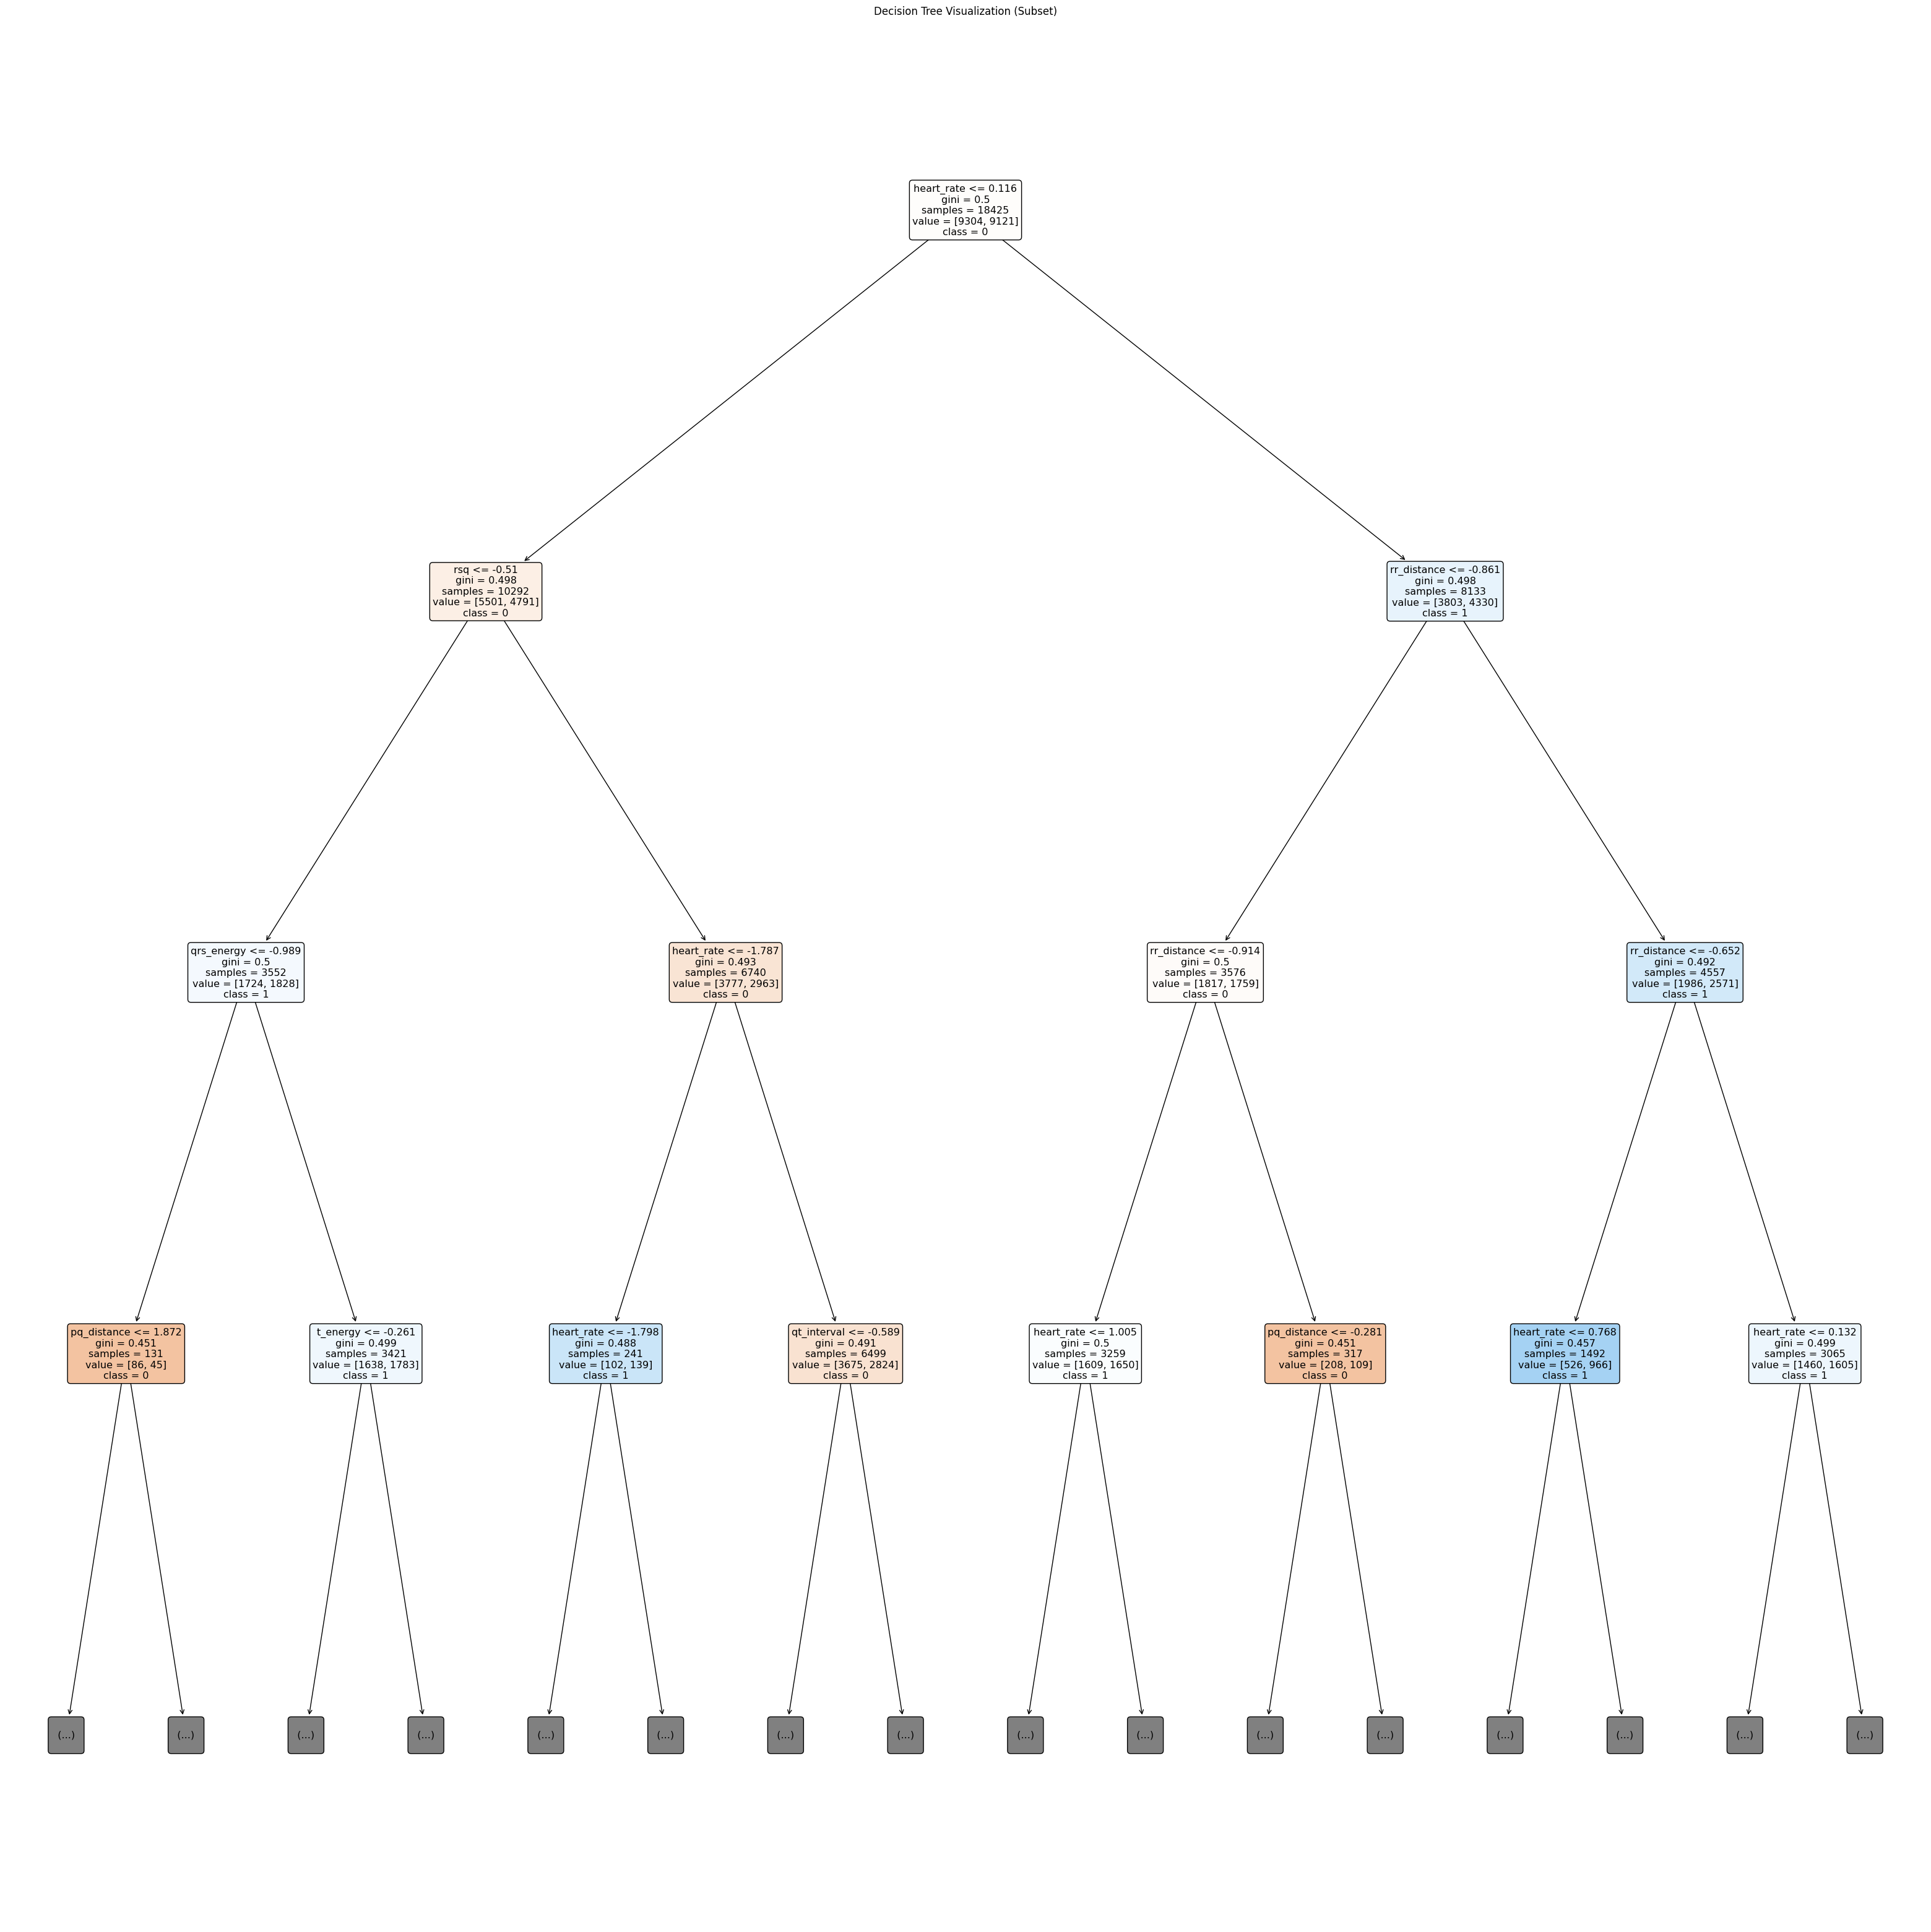

In [28]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Visualize a smaller subtree with the first few levels
plt.figure(figsize=(40, 40))
plot_tree(decision_tree_model, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in decision_tree_model.classes_], rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (Subset)")
plt.show()

## Random Forest

In [29]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.61845319 0.61872456 0.61329715 0.62523745 0.61791045]
Mean CV Accuracy: 0.6187


In [30]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6190579552854352
F1 Score: 0.6107784431137724
Precision: 0.623641304347826
Recall: 0.5984354628422425


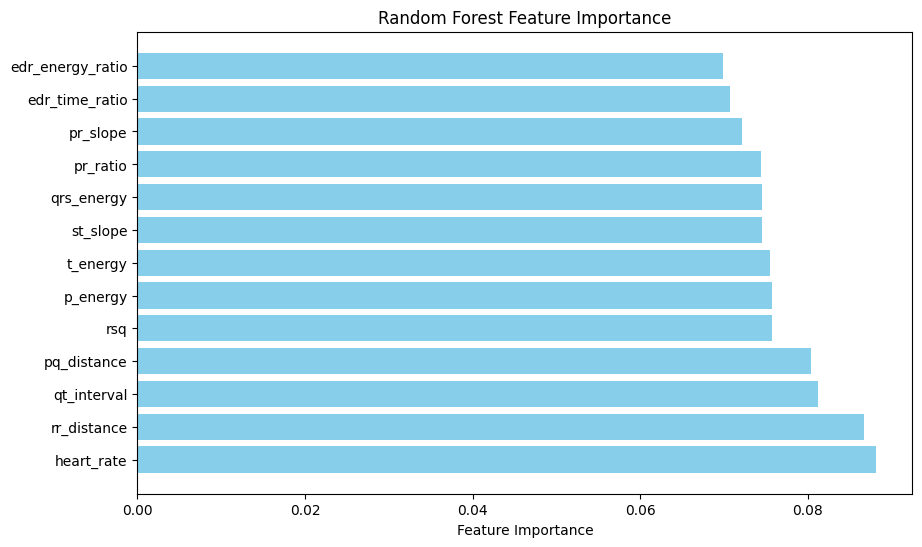

In [31]:
feature_importances = rf_model.feature_importances_

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Convert 'Feature' column values to strings (if they are not already)
feature_importance_df['Feature'] = feature_importance_df['Feature'].astype(str)

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

## Xgboost

In [32]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.60949796 0.58968792 0.59755767 0.59158752 0.60217096]
Mean CV Accuracy: 0.5981


In [33]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5960494899066637
F1 Score: 0.5939341042984945
Precision: 0.5964066608238388
Recall: 0.5914819643633203


## SVM

In [34]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.55495251 0.54382632 0.54572592 0.55658073 0.55223881]
Mean CV Accuracy: 0.5507


In [35]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.5593661818971131
F1 Score: 0.5101351351351351
Precision: 0.5735214324470971
Recall: 0.45936549326379833


## Naive Bayes

In [36]:
# Create Naive Bayes model
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

Cross-Validation Scores: [0.50909091 0.51126187 0.50203528 0.53649932 0.50936228]
Mean CV Accuracy: 0.5136


In [37]:
# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Naive Bayes Accuracy: 0.5031473844150206
Naive Bayes F1 Score: 0.22275042444821733
Naive Bayes Precision: 0.5093167701863354
Naive Bayes Recall: 0.14254671881790526


## KNN

In [38]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.56309362 0.53894166 0.54654003 0.54382632 0.54409769]
Mean CV Accuracy: 0.5473
KNN Accuracy: 0.5376600824831778
KNN F1 Score: 0.5310435931307794
KNN Precision: 0.5381526104417671
KNN Recall: 0.5241199478487614


# Models on only Lead 1 using Standard Normalization

In [39]:
# merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/Datasets/downsampled_feature_labels.csv")
# merged_df.drop("Unnamed: 0", axis=1, inplace=True)
# merged_df.dropna(inplace=True)

In [40]:
merged_df

,patient_id,lead_id,pr_ratio,rr_distance,p_energy,t_energy,pq_distance,qt_interval,st_slope,pr_slope,qrs_energy,rsq,heart_rate,edr_time_ratio,edr_energy_ratio,target
0,841,3,0.366721,478.000000,-1555.398571,19438.092411,40.500000,0.164854,0.841067,3.185830,15360.440212,-187.545848,0.125523,1.706422,1.688569,1
1,1246,1,0.082077,406.818182,895.508250,476.735491,38.500000,0.377728,1.104600,12.804097,10864.928888,1011.625930,0.147486,0.923907,0.881883,0
2,1965,11,-0.030694,408.583333,-2163.990093,8363.517222,51.846154,0.366557,4.357000,10.482548,6909.738624,1110.957393,0.146849,0.936894,0.947572,0
3,685,1,0.205195,481.666667,200.868359,2230.913728,38.400000,0.361453,0.856211,2.116685,1551.727154,247.508192,0.124567,0.532690,0.556694,1
4,1224,10,0.121137,531.375000,221.657217,6276.849541,46.222222,0.329543,5.030107,4.412079,117.010404,915.324479,0.112915,0.855738,0.857467,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23027,35,2,0.008738,399.909091,-1073.778181,4837.997201,51.000000,0.343203,2.173555,7.862139,7459.324581,748.661998,0.150034,0.700957,0.712806,1
23028,1899,6,0.055846,448.000000,-493.122610,9035.026432,63.750000,0.318452,5.968308,9.011550,7185.469411,1197.094076,0.133929,1.383858,1.366807,0
23029,194,5,0.089038,488.555556,2403.907221,905.045212,36.400000,0.550807,0.678481,11.803862,17538.407757,932.627634,0.122811,0.960699,1.099113,1
23030,1892,6,0.241178,561.000000,1174.942448,2785.616952,23.555556,0.401664,0.487198,1.524001,242.066555,19.676736,0.106952,1.664418,1.695977,0


In [41]:
merged_df["target"].value_counts()

0    11610
1    11422
Name: target, dtype: int64

In [42]:
merged_df = merged_df[merged_df["lead_id"] == 1]
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

X = merged_df.drop(["patient_id", "lead_id", "target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,pr_ratio,rr_distance,p_energy,t_energy,pq_distance,qt_interval,st_slope,pr_slope,qrs_energy,rsq,heart_rate,edr_time_ratio,edr_energy_ratio
0,-0.116283,1.186057,0.700593,-1.290162,-0.655855,0.385537,-0.438935,0.859360,0.352074,0.686161,-1.176052,-0.219023,-0.174037
1,-0.379948,1.020151,-0.220039,-0.493363,1.094749,-0.321618,-0.576919,0.132339,0.435485,0.416213,-1.059249,-1.043718,-1.082291
2,-0.197297,0.794848,0.237508,0.293842,-0.793299,-0.664309,-0.169089,0.347794,0.028601,-0.083479,-0.890522,-0.101375,0.262110
3,-0.188270,-0.367422,-0.181259,0.034591,-0.294160,-0.421659,-0.258303,0.405719,0.290294,0.147451,0.222493,-0.212371,-0.161017
4,-0.370010,-1.176797,-0.808575,0.387722,-0.655855,0.388410,0.386851,1.410206,0.426717,1.051602,1.364133,-0.581206,-0.561014
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,-0.527275,0.759345,-1.050422,1.089347,-1.408181,-0.716010,0.042908,0.602402,-0.113035,-0.226070,-0.862799,-1.123858,-1.191276
1950,0.389776,-0.343961,0.605120,-0.054832,0.326750,-0.183484,-0.639180,-0.878399,-0.549126,-0.900694,0.194911,-0.287371,-0.313525
1951,-0.724759,-1.485987,-2.353020,0.343648,-0.491887,0.955430,0.953133,1.478486,0.416300,1.391655,1.926642,-0.547294,-0.587067
1952,0.094194,-0.241959,0.197625,-1.212509,-1.050431,1.837103,-0.732937,1.273799,0.790464,0.798284,0.077941,-0.333727,-0.391266


# K-Fold

In [43]:
from sklearn.model_selection import cross_val_score, train_test_split

## Training and Testing on Complete Data

In [44]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
len(X_train), len(X_test)

(1563, 391)

In [46]:
y.value_counts()

0    983
1    971
Name: target, dtype: int64

## Logistic Regression

In [47]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

Cross-Validation Scores: [0.63897764 0.61022364 0.64536741 0.625      0.66666667]
Mean CV Accuracy: 0.6372


In [48]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.629156010230179
F1 Score: 0.6310432569974554
Precision: 0.5794392523364486
Recall: 0.6927374301675978


## Decision Trees

In [49]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.5399361  0.52076677 0.55591054 0.53525641 0.52564103]
Mean CV Accuracy: 0.5355


In [50]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5677749360613811
F1 Score: 0.546916890080429
Precision: 0.5257731958762887
Recall: 0.5698324022346368


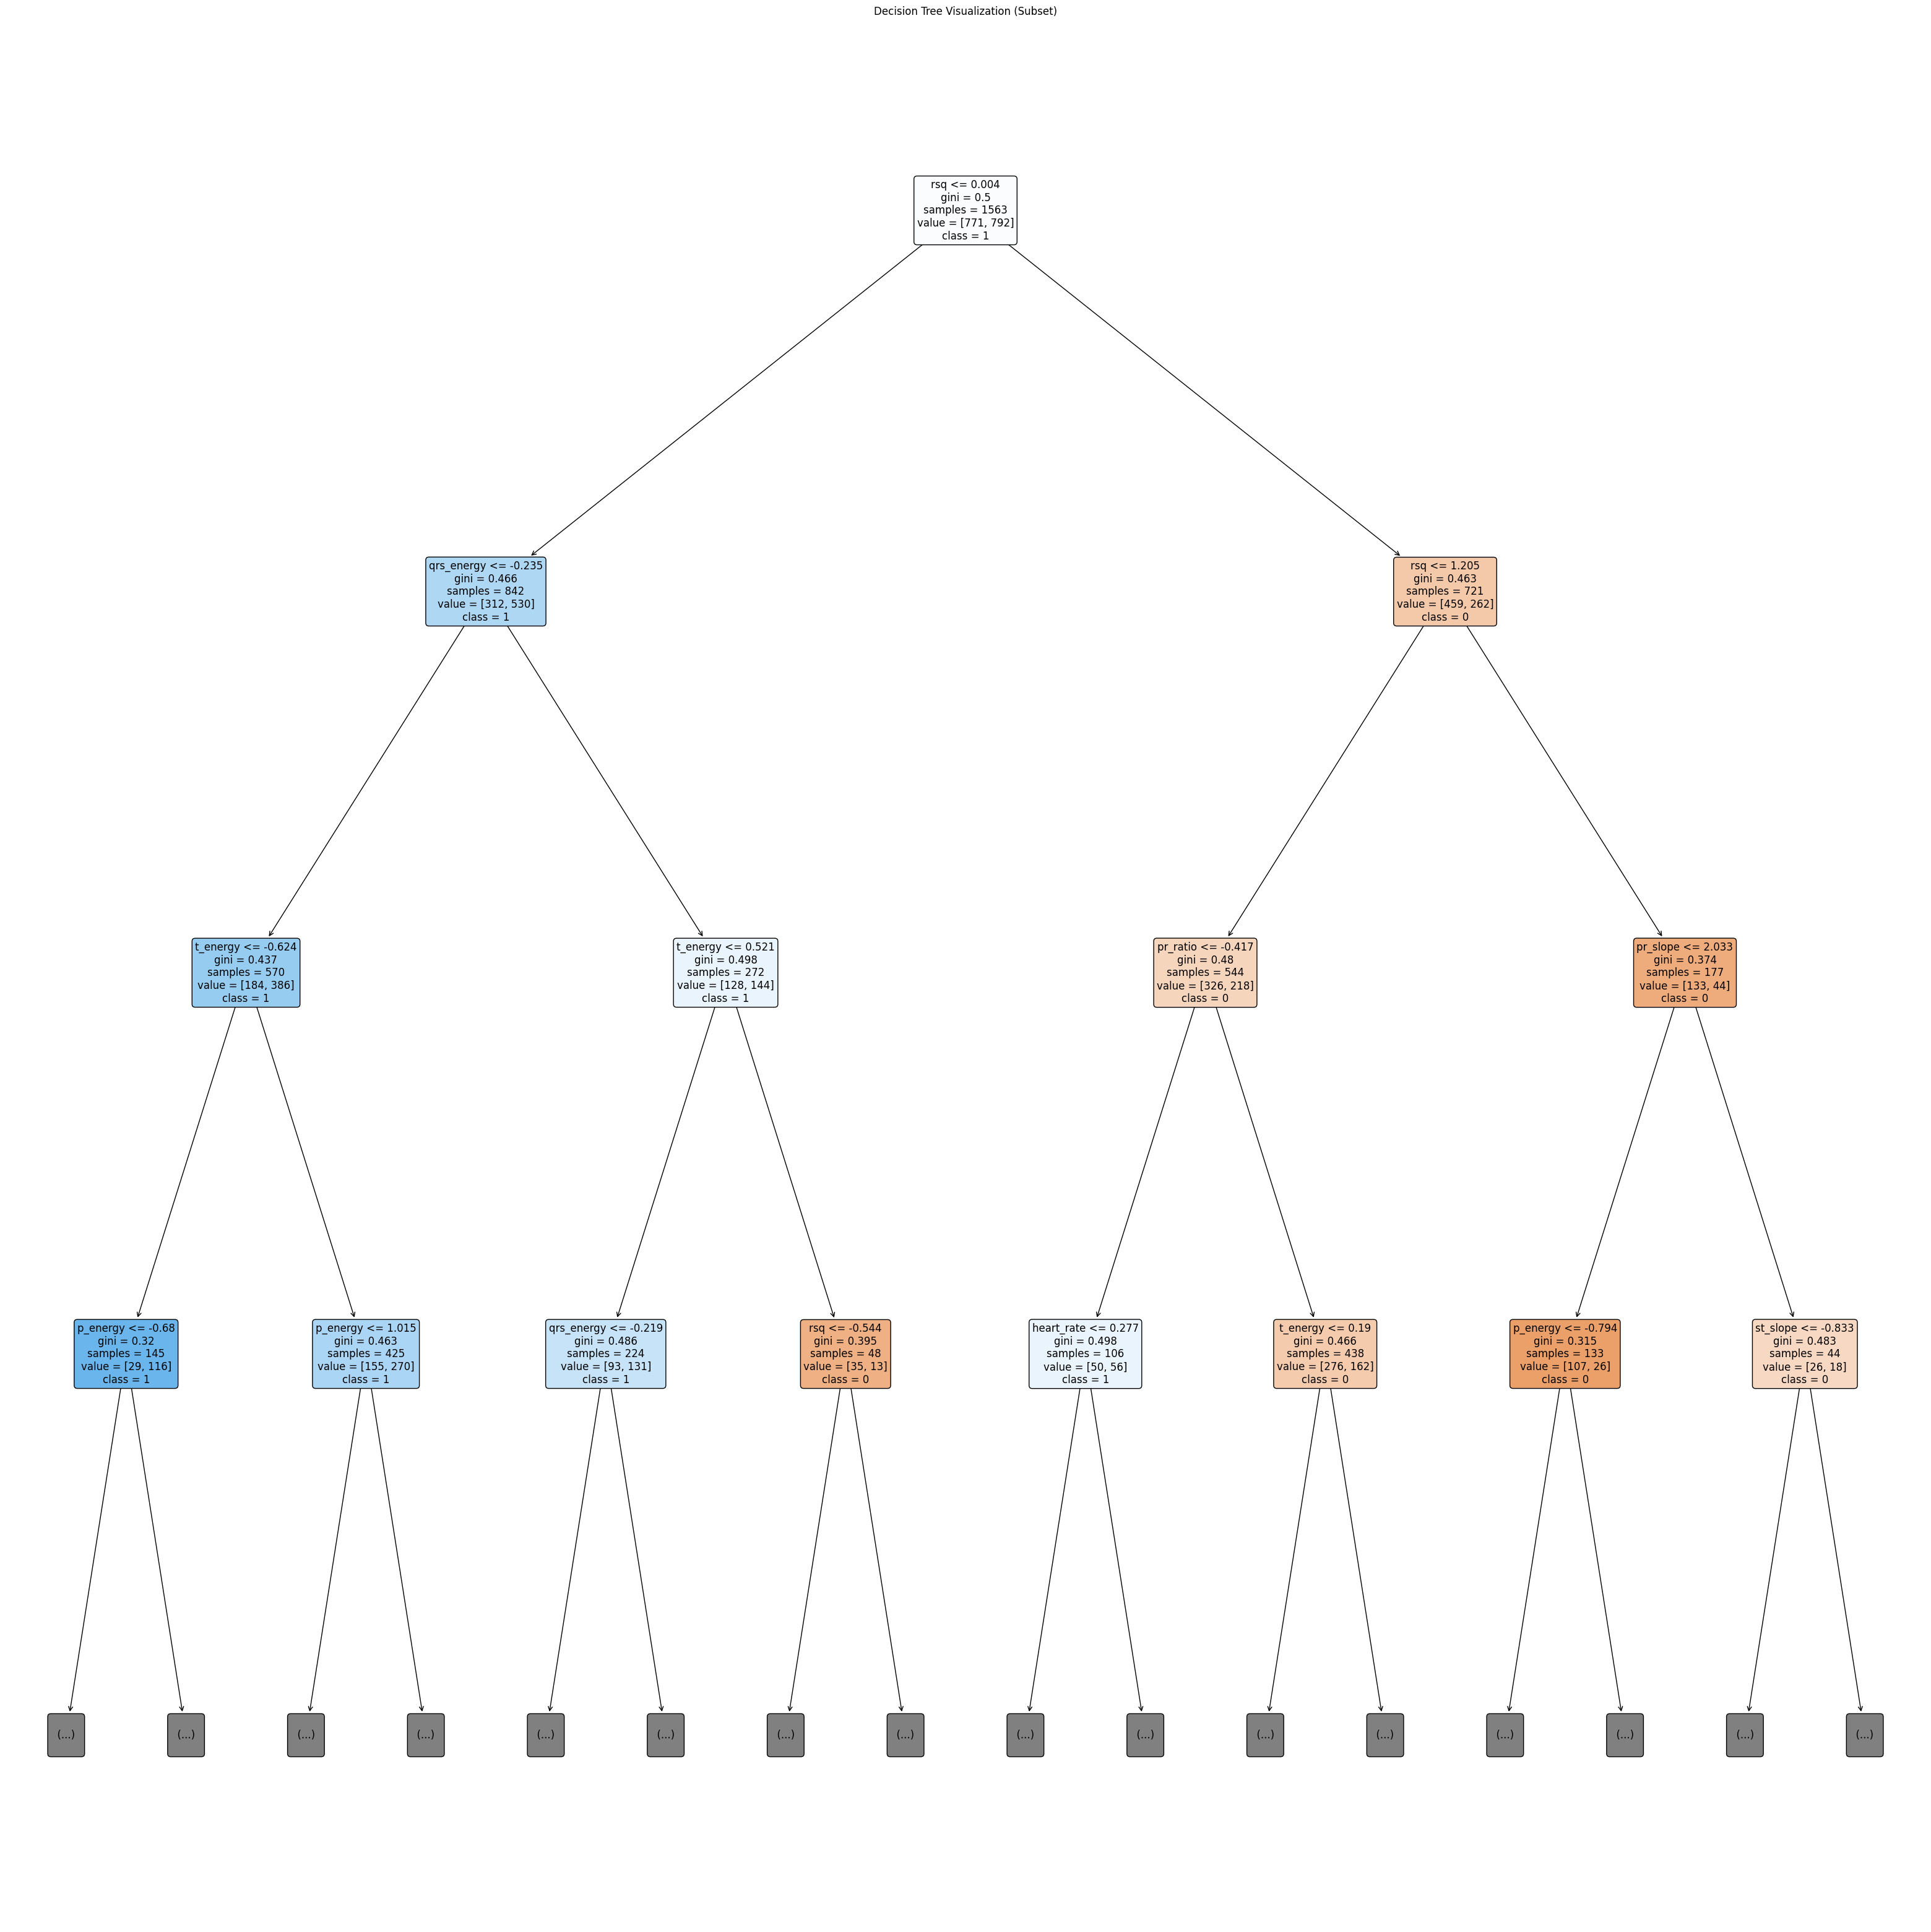

In [51]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Visualize a smaller subtree with the first few levels
plt.figure(figsize=(40, 40))
plot_tree(decision_tree_model, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in decision_tree_model.classes_], rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (Subset)")
plt.show()

## Random Forest

In [52]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.61022364 0.59744409 0.62300319 0.58012821 0.61858974]
Mean CV Accuracy: 0.6059


In [53]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6138107416879796
F1 Score: 0.5817174515235456
Precision: 0.5769230769230769
Recall: 0.5865921787709497


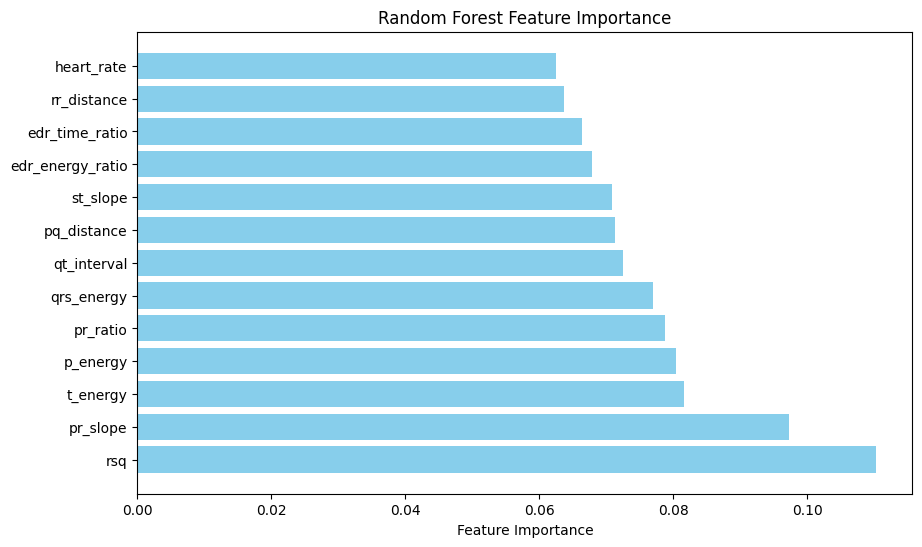

In [54]:
feature_importances = rf_model.feature_importances_

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Convert 'Feature' column values to strings (if they are not already)
feature_importance_df['Feature'] = feature_importance_df['Feature'].astype(str)

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

## Xgboost

In [55]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.57188498 0.58466454 0.60702875 0.51923077 0.58333333]
Mean CV Accuracy: 0.5732


In [56]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5882352941176471
F1 Score: 0.5636856368563685
Precision: 0.5473684210526316
Recall: 0.5810055865921788


## SVM

In [57]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.62619808 0.60702875 0.63258786 0.57692308 0.66987179]
Mean CV Accuracy: 0.6225


In [58]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.6214833759590793
F1 Score: 0.6224489795918366
Precision: 0.5727699530516432
Recall: 0.6815642458100558


## Naive Bayes

In [59]:
# Create Naive Bayes model
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

Cross-Validation Scores: [0.58785942 0.60063898 0.65175719 0.61538462 0.66346154]
Mean CV Accuracy: 0.6238


In [60]:
# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Naive Bayes Accuracy: 0.6265984654731458
Naive Bayes F1 Score: 0.6117021276595744
Naive Bayes Precision: 0.583756345177665
Naive Bayes Recall: 0.6424581005586593


## KNN

In [61]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.57507987 0.60063898 0.5686901  0.54487179 0.57051282]
Mean CV Accuracy: 0.5720
KNN Accuracy: 0.5524296675191815
KNN F1 Score: 0.5501285347043701
KNN Precision: 0.5095238095238095
KNN Recall: 0.5977653631284916


# Models trained on Lead 1+2+3 = 33 features using Standard Normalization

In [62]:
# merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/Datasets/downsampled_feature_labels.csv")
# merged_df.drop("Unnamed: 0", axis=1, inplace=True)
# # merged_df.dropna(inplace=True)

In [63]:
merged_df = merged_df[merged_df["lead_id"] < 4]
merged_df

,patient_id,lead_id,pr_ratio,rr_distance,p_energy,t_energy,pq_distance,qt_interval,st_slope,pr_slope,qrs_energy,rsq,heart_rate,edr_time_ratio,edr_energy_ratio,target
0,1224,1,0.050265,531.500000,441.359437,-283.372073,43.000000,0.411205,1.540158,9.713436,7592.911954,921.837500,0.112888,0.915803,0.938199,0
1,1455,1,0.000822,518.000000,-630.451395,2072.995022,67.200000,0.354633,1.310752,7.067799,7969.261897,839.146250,0.115830,0.262581,0.292069,0
2,293,1,0.035074,499.666667,-97.770134,4400.990547,41.100000,0.327218,1.988795,7.851840,6133.405558,686.078817,0.120080,1.008989,1.248474,1
3,1586,1,0.036766,405.090909,-585.303906,3634.309803,48.000000,0.346630,1.840472,8.062630,7314.163188,756.818025,0.148115,0.921072,0.947462,0
4,2006,1,0.002686,339.230769,-1315.632334,4678.622409,43.000000,0.411435,2.913081,11.717970,7929.702639,1033.780660,0.176871,0.628926,0.662905,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,1931,1,-0.026804,496.777778,-1597.194408,6753.531797,32.600000,0.323082,2.341254,8.778364,5494.343661,642.399911,0.120778,0.199104,0.214537,0
1950,1965,1,0.145162,407.000000,330.208584,3369.859180,56.583333,0.365684,1.207240,3.389711,3526.706473,435.746838,0.147420,0.861666,0.838968,0
1951,1509,1,-0.063837,314.071429,-3113.695164,4548.280826,45.266667,0.456796,3.854562,11.966444,7882.702560,1137.946622,0.191039,0.655787,0.644370,0
1952,1109,1,0.089734,415.300000,-144.201532,-53.728338,37.545455,0.527330,1.051363,11.221584,9570.923437,956.183300,0.144474,0.824949,0.783663,0


In [64]:
merged_df.columns

Index(['patient_id', 'lead_id', 'pr_ratio', 'rr_distance', 'p_energy',
       't_energy', 'pq_distance', 'qt_interval', 'st_slope', 'pr_slope',
       'qrs_energy', 'rsq', 'heart_rate', 'edr_time_ratio', 'edr_energy_ratio',
       'target'],
      dtype='object')

In [65]:
pivoted_df = merged_df.pivot(index='patient_id', columns='lead_id',\
                             values=['pr_ratio', 'rr_distance', 'p_energy',\
                                     't_energy', 'pq_distance', 'qt_interval',\
                                     'st_slope', 'pr_slope', 'qrs_energy',\
                                     'rsq', 'heart_rate', 'edr_time_ratio', 'edr_energy_ratio'])
pivoted_df.sort_index(axis=1, level=1, inplace=True)


In [66]:
pivoted_df

,edr_energy_ratio,edr_time_ratio,heart_rate,p_energy,pq_distance,pr_ratio,pr_slope,qrs_energy,qt_interval,rr_distance,rsq,st_slope,t_energy
lead_id,1,1,1,1,1,1,1,1,1,1,1,1,1
patient_id,,,,,,,,,,,,,
0,1.011732,1.007608,0.159116,-3297.249202,57.000000,-0.054317,8.642640,8564.971669,0.404318,377.083333,913.046274,3.122865,5756.845777
1,0.786049,0.942913,0.138440,-1001.362997,54.090909,-0.040611,5.299051,4941.067796,0.379452,433.400000,513.379424,1.114519,3334.747737
2,1.089178,1.237727,0.148791,-1269.905400,54.692308,-0.023139,9.273605,7967.382615,0.362249,403.250000,832.508448,1.225424,162.780795
3,1.149821,1.001017,0.118838,-553.935848,33.100000,0.072957,6.661890,4107.674542,0.327201,504.888889,563.954420,1.487061,3490.376362
4,0.748991,0.741321,0.111784,609.882044,49.555556,0.076716,4.808076,3653.719432,0.284635,536.750000,582.273586,2.754657,6479.735615
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,0.722308,0.725112,0.140695,-189.504576,66.083333,0.034634,7.767104,8672.426609,0.335518,426.454545,984.522061,2.678735,3447.202520
2160,0.839059,0.805867,0.149694,1087.134766,40.250000,0.205243,3.522456,2614.849116,0.513117,400.818182,485.701786,1.257056,653.263021


In [67]:
pivoted_df = pivoted_df.reset_index()
pivoted_df

,patient_id,edr_energy_ratio,edr_time_ratio,heart_rate,p_energy,pq_distance,pr_ratio,pr_slope,qrs_energy,qt_interval,rr_distance,rsq,st_slope,t_energy
lead_id,,1,1,1,1,1,1,1,1,1,1,1,1,1
0,0,1.011732,1.007608,0.159116,-3297.249202,57.000000,-0.054317,8.642640,8564.971669,0.404318,377.083333,913.046274,3.122865,5756.845777
1,1,0.786049,0.942913,0.138440,-1001.362997,54.090909,-0.040611,5.299051,4941.067796,0.379452,433.400000,513.379424,1.114519,3334.747737
2,2,1.089178,1.237727,0.148791,-1269.905400,54.692308,-0.023139,9.273605,7967.382615,0.362249,403.250000,832.508448,1.225424,162.780795
3,3,1.149821,1.001017,0.118838,-553.935848,33.100000,0.072957,6.661890,4107.674542,0.327201,504.888889,563.954420,1.487061,3490.376362
4,4,0.748991,0.741321,0.111784,609.882044,49.555556,0.076716,4.808076,3653.719432,0.284635,536.750000,582.273586,2.754657,6479.735615
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,2159,0.722308,0.725112,0.140695,-189.504576,66.083333,0.034634,7.767104,8672.426609,0.335518,426.454545,984.522061,2.678735,3447.202520
1950,2160,0.839059,0.805867,0.149694,1087.134766,40.250000,0.205243,3.522456,2614.849116,0.513117,400.818182,485.701786,1.257056,653.263021
1951,2161,1.142280,1.028140,0.138857,-172.382407,98.636364,0.013340,7.412361,11220.377567,0.365235,432.100000,1241.105824,2.642689,4798.481909


In [68]:
merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')

<ipython-input-68-2fe9fba29447>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')


In [69]:
merged_df.dropna(inplace=True)

In [70]:
merged_df.columns

Index([           'patient_id',      ('patient_id', ''),
       ('edr_energy_ratio', 1),   ('edr_time_ratio', 1),
             ('heart_rate', 1),         ('p_energy', 1),
            ('pq_distance', 1),         ('pr_ratio', 1),
               ('pr_slope', 1),       ('qrs_energy', 1),
            ('qt_interval', 1),      ('rr_distance', 1),
                    ('rsq', 1),         ('st_slope', 1),
               ('t_energy', 1),                'target'],
      dtype='object')

In [71]:
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

merged_df = merged_df.iloc[:,2:]

X = merged_df.drop(["target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,"(edr_energy_ratio, 1)","(edr_time_ratio, 1)","(heart_rate, 1)","(p_energy, 1)","(pq_distance, 1)","(pr_ratio, 1)","(pr_slope, 1)","(qrs_energy, 1)","(qt_interval, 1)","(rr_distance, 1)","(rsq, 1)","(st_slope, 1)","(t_energy, 1)"
0,0.100790,-0.002857,0.032229,1.356755,-0.360471,0.219519,0.308137,-0.318493,-0.308053,-0.200958,1.170455,1.524737,0.382725
1,0.129435,0.087519,-0.066127,-2.055336,-1.326635,-0.626235,3.056707,1.272909,-0.347790,-0.110464,1.667048,0.624582,2.027145
2,0.185924,0.183830,-0.106524,-0.494830,1.974654,-0.384535,0.206120,0.784337,-0.011517,-0.072367,0.529017,-0.603627,-1.263541
3,-0.694678,-0.642534,-0.587448,-0.735354,-0.563787,-0.292932,1.928701,1.165797,-0.775571,0.427807,1.648200,0.474380,0.959078
4,-0.132541,-0.225844,0.458585,-1.266687,0.302637,-0.591164,1.416569,3.356011,3.981007,-0.559582,1.172318,-0.926772,-1.006182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1949,-0.353756,-0.340601,-0.516312,0.348774,-0.978092,-0.161431,-0.018184,-0.269937,0.155896,0.347927,-0.409147,-0.693543,-1.394378
1950,-0.280635,-0.428480,0.102276,-0.527472,-1.771081,-1.094864,-1.041471,-1.258995,-0.459863,-0.263521,-1.441946,-0.370063,-0.335473
1951,-0.342809,-0.324570,1.793889,-0.071745,1.135926,-0.226628,-0.459003,-0.318210,3.057115,-1.417226,-0.724590,-0.344686,-0.342196
1952,-0.558279,-0.514283,0.794718,0.448750,-0.505612,0.077068,1.012200,1.106003,1.553868,-0.808906,0.627737,-0.770270,-1.486937


## Training and Testing on Complete Data

In [72]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
len(X_train), len(X_test)

(1563, 391)

In [74]:
y.value_counts()

0    983
1    971
Name: target, dtype: int64

## Logistic Regression

In [75]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

Cross-Validation Scores: [0.70607029 0.61022364 0.64536741 0.63141026 0.58333333]
Mean CV Accuracy: 0.6353


In [76]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6086956521739131
F1 Score: 0.5963060686015831
Precision: 0.5854922279792746
Recall: 0.6075268817204301


## Decision Trees

In [77]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.55591054 0.55271565 0.55910543 0.51602564 0.53525641]
Mean CV Accuracy: 0.5438


In [78]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5370843989769821
F1 Score: 0.519893899204244
Precision: 0.5130890052356021
Recall: 0.5268817204301075


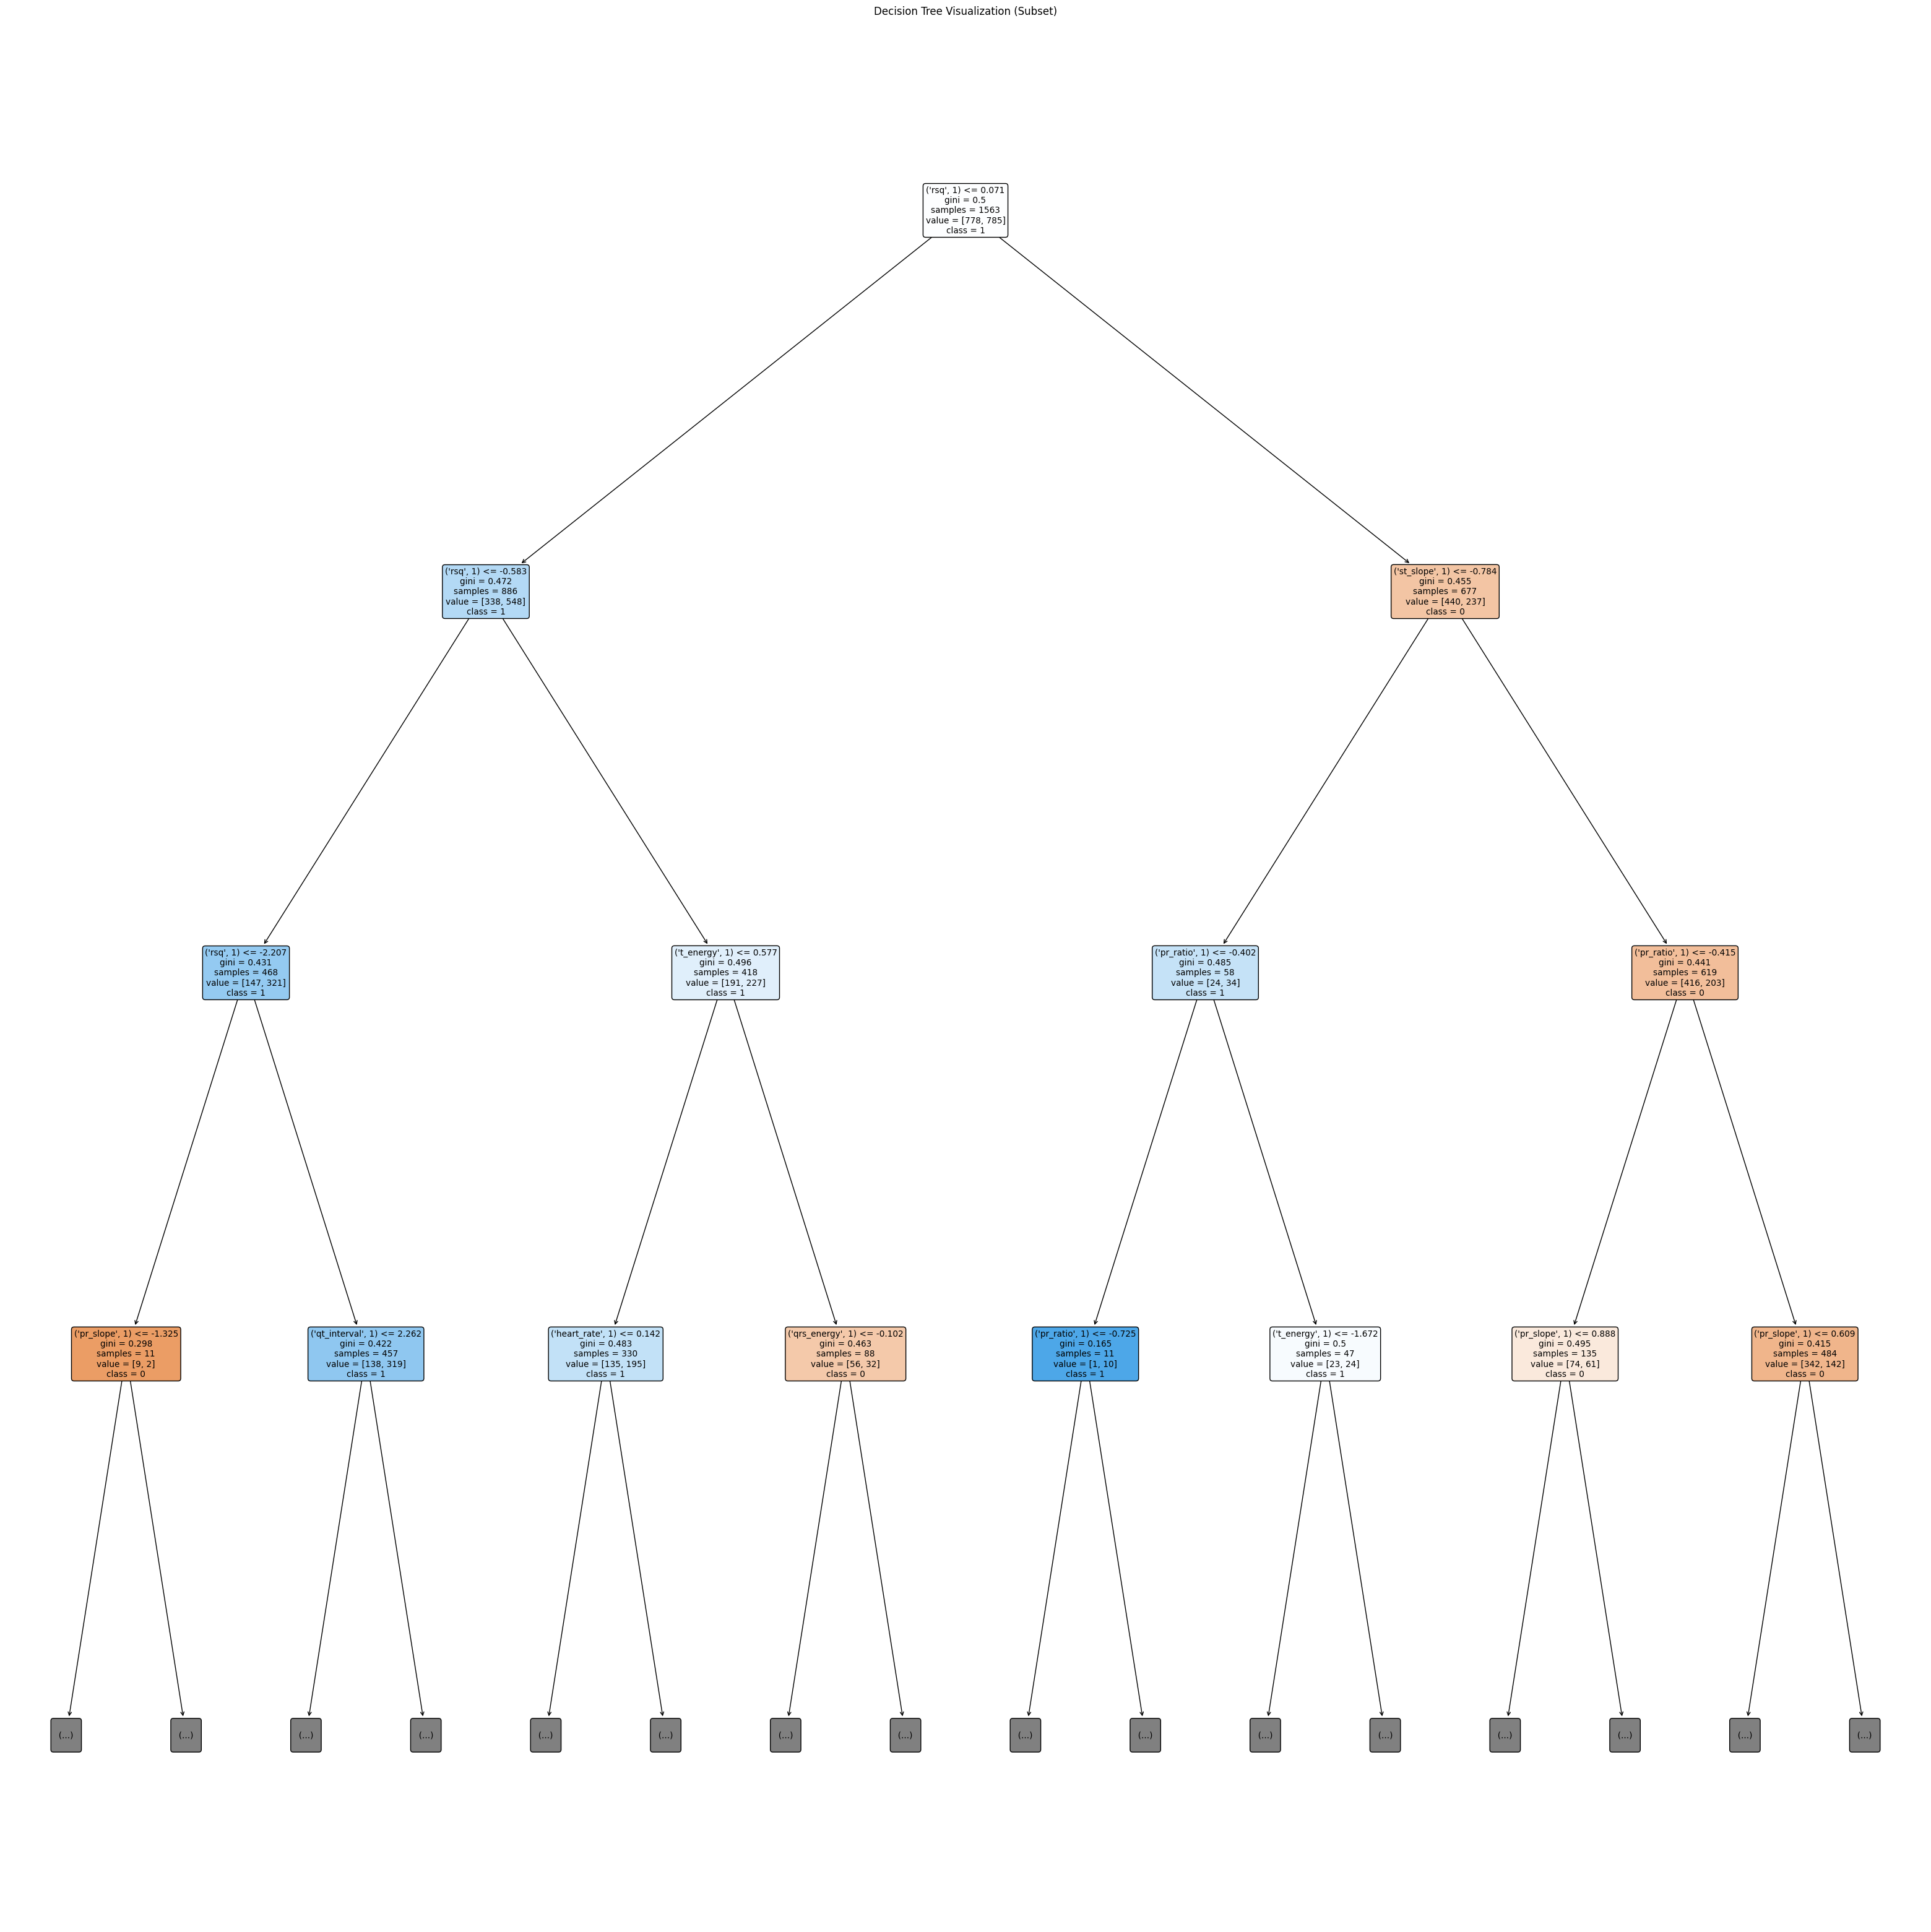

In [79]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Visualize a smaller subtree with the first few levels
plt.figure(figsize=(40, 40))
plot_tree(decision_tree_model, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in decision_tree_model.classes_], rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (Subset)")
plt.show()

## Random Forest

In [80]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.62939297 0.57507987 0.64536741 0.59935897 0.58333333]
Mean CV Accuracy: 0.6065


In [81]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5856777493606138
F1 Score: 0.5524861878453038
Precision: 0.5681818181818182
Recall: 0.5376344086021505


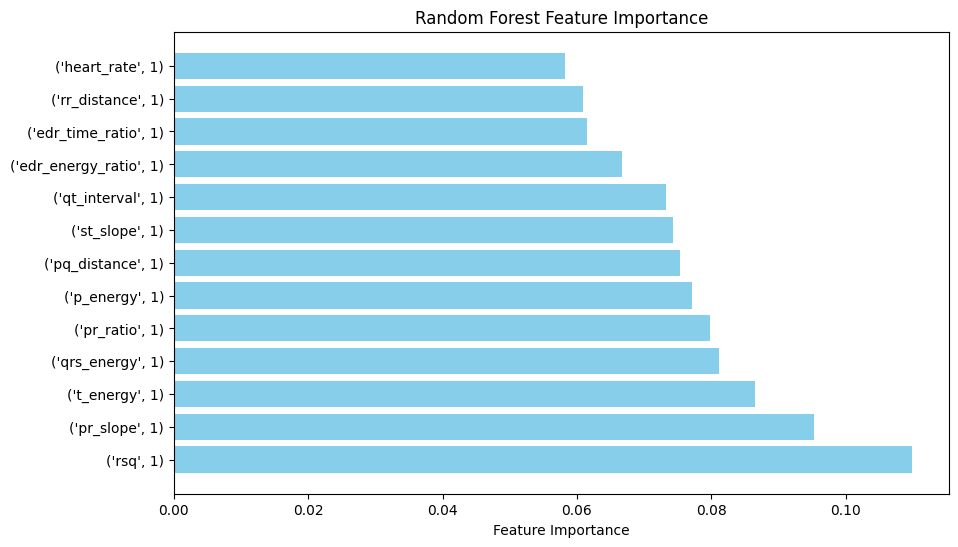

In [82]:
feature_importances = rf_model.feature_importances_

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Convert 'Feature' column values to strings (if they are not already)
feature_importance_df['Feature'] = feature_importance_df['Feature'].astype(str)

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

## Xgboost

In [83]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.56230032 0.55910543 0.62300319 0.58974359 0.55769231]
Mean CV Accuracy: 0.5784


In [84]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5703324808184144
F1 Score: 0.5602094240837696
Precision: 0.5459183673469388
Recall: 0.5752688172043011


## SVM

In [85]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.69329073 0.58466454 0.67092652 0.61217949 0.59935897]
Mean CV Accuracy: 0.6321


In [86]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.6163682864450127
F1 Score: 0.6052631578947368
Precision: 0.5927835051546392
Recall: 0.6182795698924731


## Naive Bayes

In [87]:
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Cross-Validation Scores: [0.61022364 0.57188498 0.60702875 0.61217949 0.57692308]
Mean CV Accuracy: 0.5956
Naive Bayes Accuracy: 0.5933503836317136
Naive Bayes F1 Score: 0.4717607973421927
Naive Bayes Precision: 0.6173913043478261
Naive Bayes Recall: 0.3817204301075269


## KNN

In [88]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.61980831 0.53354633 0.57827476 0.55128205 0.54487179]
Mean CV Accuracy: 0.5656
KNN Accuracy: 0.5601023017902813
KNN F1 Score: 0.5449735449735449
KNN Precision: 0.5364583333333334
KNN Recall: 0.553763440860215


# Models trained on Lead 1+2+3 ...+12 = 132 features using Standard Normalization

In [89]:
merged_df = pd.read_csv("/content/drive/MyDrive/DIS_Dr_Liu/new_features_merged.csv")
merged_df.drop("Unnamed: 0", axis=1, inplace=True)
merged_df.dropna(inplace=True)

In [90]:
# merged_df = merged_df[merged_df["lead_id"] < 4]
merged_df

,patient_id,lead_id,pr_ratio,rr_distance,p_energy,t_energy,pq_distance,qt_interval,st_slope,pr_slope,qrs_energy,rsq,heart_rate,edr_time_ratio,edr_energy_ratio,target
0,0,1,-0.054317,377.083333,-3297.249202,5756.845777,57.000000,0.404318,3.122865,8.642640,8564.971669,913.046274,0.159116,1.007608,1.011732,1
1,0,2,0.173118,377.166667,9.640745,2769.939236,57.692308,0.441143,1.907872,2.284969,1435.067840,444.574330,0.159081,0.876788,0.744761,1
2,0,3,0.803948,411.090909,3226.989388,861.597898,46.833333,0.373397,5.337444,0.085836,-1520.994131,447.789323,0.145953,0.959859,0.946903,1
3,0,4,0.763358,383.000000,2931.324322,2988.418158,66.461538,0.271741,8.208612,0.346546,48.321557,401.243304,0.156658,1.140411,1.100461,1
4,0,5,-0.058833,411.272727,-3019.002055,4359.392590,43.916667,0.360466,2.422612,9.218017,8780.695173,786.025130,0.145889,1.045801,0.947137,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23027,2163,8,0.488058,455.800000,162.286435,2295.213058,67.909091,0.162152,5.545811,0.418477,-4305.583086,635.646834,0.131637,0.953257,0.937737,0
23028,2163,9,-0.016470,471.625000,-9889.188938,-2982.607416,52.888889,0.537857,-1.348335,3.153742,16201.075260,511.905208,0.127220,1.879499,1.736153,0
23029,2163,10,0.477778,428.800000,-3090.423671,-302.615363,64.272727,0.633480,0.746142,1.198969,12511.021144,368.125365,0.139925,1.033777,1.018536,0
23030,2163,11,-0.089861,428.500000,-2825.421094,10080.342482,52.363636,0.384428,4.580217,7.207576,4125.364610,804.815869,0.140023,1.602314,1.578354,0


In [91]:
merged_df.columns

Index(['patient_id', 'lead_id', 'pr_ratio', 'rr_distance', 'p_energy',
       't_energy', 'pq_distance', 'qt_interval', 'st_slope', 'pr_slope',
       'qrs_energy', 'rsq', 'heart_rate', 'edr_time_ratio', 'edr_energy_ratio',
       'target'],
      dtype='object')

In [92]:
pivoted_df = merged_df.pivot(index='patient_id', columns='lead_id',\
                             values=['pr_ratio', 'rr_distance', 'p_energy',\
                                     't_energy', 'pq_distance', 'qt_interval',\
                                     'st_slope', 'pr_slope', 'qrs_energy',\
                                     'rsq', 'heart_rate', 'edr_time_ratio', 'edr_energy_ratio'])
pivoted_df.sort_index(axis=1, level=1, inplace=True)


In [93]:
pivoted_df

,edr_energy_ratio,edr_time_ratio,heart_rate,p_energy,pq_distance,pr_ratio,pr_slope,qrs_energy,qt_interval,rr_distance,...,p_energy,pq_distance,pr_ratio,pr_slope,qrs_energy,qt_interval,rr_distance,rsq,st_slope,t_energy
lead_id,1,1,1,1,1,1,1,1,1,1,...,12,12,12,12,12,12,12,12,12,12
patient_id,,,,,,,,,,,,,,,,,,,,,
0,1.011732,1.007608,0.159116,-3297.249202,57.000000,-0.054317,8.642640,8564.971669,0.404318,377.083333,...,-2098.180632,60.769231,-0.055422,5.886681,6770.553099,0.423604,377.166667,599.476494,1.221051,3837.602229
1,0.786049,0.942913,0.138440,-1001.362997,54.090909,-0.040611,5.299051,4941.067796,0.379452,433.400000,...,-2152.072656,52.000000,-0.060623,8.317649,7397.271479,0.393716,433.400000,709.301096,1.606917,6137.914844
2,1.089178,1.237727,0.148791,-1269.905400,54.692308,-0.023139,9.273605,7967.382615,0.362249,403.250000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.149821,1.001017,0.118838,-553.935848,33.100000,0.072957,6.661890,4107.674542,0.327201,504.888889,...,-2151.372463,38.272727,-0.031627,12.522358,9223.532965,0.368318,454.400000,938.302902,1.805229,3623.569420
4,0.748991,0.741321,0.111784,609.882044,49.555556,0.076716,4.808076,3653.719432,0.284635,536.750000,...,-815.088405,41.555556,0.012516,16.558843,14588.307639,0.302231,536.750000,1351.676935,3.293137,9034.145288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2159,0.722308,0.725112,0.140695,-189.504576,66.083333,0.034634,7.767104,8672.426609,0.335518,426.454545,...,-897.038099,72.909091,-0.005981,8.518245,11093.410126,0.374153,420.100000,1071.009842,2.013878,1834.558665
2160,0.839059,0.805867,0.149694,1087.134766,40.250000,0.205243,3.522456,2614.849116,0.513117,400.818182,...,-381.743527,48.750000,0.026281,6.119403,5792.983361,0.487960,400.818182,610.356882,1.061287,1522.876237


In [94]:
pivoted_df = pivoted_df.reset_index()
pivoted_df

,patient_id,edr_energy_ratio,edr_time_ratio,heart_rate,p_energy,pq_distance,pr_ratio,pr_slope,qrs_energy,qt_interval,...,p_energy,pq_distance,pr_ratio,pr_slope,qrs_energy,qt_interval,rr_distance,rsq,st_slope,t_energy
lead_id,,1,1,1,1,1,1,1,1,1,...,12,12,12,12,12,12,12,12,12,12
0,0,1.011732,1.007608,0.159116,-3297.249202,57.000000,-0.054317,8.642640,8564.971669,0.404318,...,-2098.180632,60.769231,-0.055422,5.886681,6770.553099,0.423604,377.166667,599.476494,1.221051,3837.602229
1,1,0.786049,0.942913,0.138440,-1001.362997,54.090909,-0.040611,5.299051,4941.067796,0.379452,...,-2152.072656,52.000000,-0.060623,8.317649,7397.271479,0.393716,433.400000,709.301096,1.606917,6137.914844
2,2,1.089178,1.237727,0.148791,-1269.905400,54.692308,-0.023139,9.273605,7967.382615,0.362249,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,1.149821,1.001017,0.118838,-553.935848,33.100000,0.072957,6.661890,4107.674542,0.327201,...,-2151.372463,38.272727,-0.031627,12.522358,9223.532965,0.368318,454.400000,938.302902,1.805229,3623.569420
4,4,0.748991,0.741321,0.111784,609.882044,49.555556,0.076716,4.808076,3653.719432,0.284635,...,-815.088405,41.555556,0.012516,16.558843,14588.307639,0.302231,536.750000,1351.676935,3.293137,9034.145288
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2157,2159,0.722308,0.725112,0.140695,-189.504576,66.083333,0.034634,7.767104,8672.426609,0.335518,...,-897.038099,72.909091,-0.005981,8.518245,11093.410126,0.374153,420.100000,1071.009842,2.013878,1834.558665
2158,2160,0.839059,0.805867,0.149694,1087.134766,40.250000,0.205243,3.522456,2614.849116,0.513117,...,-381.743527,48.750000,0.026281,6.119403,5792.983361,0.487960,400.818182,610.356882,1.061287,1522.876237
2159,2161,1.142280,1.028140,0.138857,-172.382407,98.636364,0.013340,7.412361,11220.377567,0.365235,...,-439.268862,97.200000,0.010766,5.340615,7199.084107,0.362545,432.222222,975.550223,3.473676,5389.586808


In [95]:
merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')

<ipython-input-95-2fe9fba29447>:1: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  merged_df = pd.merge(pivoted_df, target_df, on='patient_id', how='inner')


In [96]:
merged_df.dropna(inplace=True)

In [97]:
merged_df.columns

Index([           'patient_id',      ('patient_id', ''),
       ('edr_energy_ratio', 1),   ('edr_time_ratio', 1),
             ('heart_rate', 1),         ('p_energy', 1),
            ('pq_distance', 1),         ('pr_ratio', 1),
               ('pr_slope', 1),       ('qrs_energy', 1),
       ...
           ('pq_distance', 12),        ('pr_ratio', 12),
              ('pr_slope', 12),      ('qrs_energy', 12),
           ('qt_interval', 12),     ('rr_distance', 12),
                   ('rsq', 12),        ('st_slope', 12),
              ('t_energy', 12),                'target'],
      dtype='object', length=159)

In [98]:
merged_df = merged_df.sample(frac=1).reset_index(drop=True)

merged_df = merged_df.iloc[:,2:]

X = merged_df.drop(["target"], axis=1)
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X

,"(edr_energy_ratio, 1)","(edr_time_ratio, 1)","(heart_rate, 1)","(p_energy, 1)","(pq_distance, 1)","(pr_ratio, 1)","(pr_slope, 1)","(qrs_energy, 1)","(qt_interval, 1)","(rr_distance, 1)",...,"(p_energy, 12)","(pq_distance, 12)","(pr_ratio, 12)","(pr_slope, 12)","(qrs_energy, 12)","(qt_interval, 12)","(rr_distance, 12)","(rsq, 12)","(st_slope, 12)","(t_energy, 12)"
0,-0.019066,0.154482,-0.308341,-0.014967,0.040277,-0.274465,-0.022289,-0.288553,-0.001320,0.144436,...,-0.147801,0.344938,-0.434749,-0.586435,-0.428431,-0.343981,0.177194,-0.727617,-0.390586,0.483055
1,-0.176440,-0.192908,2.103183,0.503117,-1.061570,0.190965,0.788093,0.280046,1.060526,-1.624107,...,0.208080,-0.731871,-0.073554,-0.475503,-0.680833,0.644479,-1.589334,-0.684035,-0.280804,-0.529993
2,-0.589069,-0.547525,-1.324788,0.013738,-1.024765,0.033977,-0.657250,-0.757066,-1.162221,1.418871,...,0.657814,-0.712916,0.214656,0.347682,0.015456,-1.103814,1.450177,0.323991,0.127211,-0.189669
3,-0.065850,-0.189930,-0.638097,0.534721,0.816339,0.071319,-0.223736,1.635763,0.029079,0.506429,...,0.502974,0.206061,0.088596,-0.264532,1.142270,-0.062343,0.911336,0.066866,0.296906,-1.207498
4,0.246820,0.208813,-0.099568,-1.505197,0.244590,-0.458896,-0.063989,0.085414,-0.680227,-0.064365,...,-0.633789,-0.474221,-0.288588,0.299476,-0.954106,-0.595684,-0.031369,1.623245,4.406165,2.609263
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1214,-1.094509,-1.042657,0.038572,0.072287,1.169844,-0.236549,-0.461158,-0.221746,-0.048624,-0.194785,...,0.074143,1.118611,-0.115824,0.030041,0.333475,0.055667,-0.162817,0.089898,-0.676053,-0.421808
1215,0.867557,0.505464,-0.137912,-0.735264,-0.444626,-0.480187,-1.029535,-0.960490,-0.912720,-0.027102,...,0.773185,-0.021618,0.566042,-0.876463,-1.030126,-0.572383,-0.484004,-0.472106,0.999816,0.650999
1216,0.347137,0.286071,0.602056,3.354086,0.935518,1.806537,-1.007088,-1.630993,0.275437,-0.671543,...,0.786302,0.494200,0.318951,0.087760,-0.281449,0.213174,-0.638941,0.715664,1.010325,0.443265
1217,-0.167524,-0.245025,0.697911,-0.333759,-0.899185,-0.293076,-0.810868,-1.151947,0.196174,-0.744841,...,-1.168771,-0.605503,-0.946688,-0.460259,-0.988405,0.099752,-0.709894,-0.486475,0.681331,0.244334


## Training and Testing on Complete Data

In [99]:
y = merged_df.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [100]:
len(X_train), len(X_test)

(975, 244)

In [101]:
y.value_counts()

0    611
1    608
Name: target, dtype: int64

## Logistic Regression

In [102]:
logress_model = LogisticRegression()

k_fold = 5
cv_scores = cross_val_score(logress_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

logress_model.fit(X_train, y_train)

log1_pred = logress_model.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Cross-Validation Scores: [0.55897436 0.64102564 0.63589744 0.65128205 0.61025641]
Mean CV Accuracy: 0.6195


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [103]:
accuracy = accuracy_score(y_test, log1_pred)
f1 = f1_score(y_test, log1_pred)
precision = precision_score(y_test, log1_pred)
recall = recall_score(y_test, log1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6147540983606558
F1 Score: 0.5982905982905983
Precision: 0.6140350877192983
Recall: 0.5833333333333334


## Decision Trees

In [104]:
decision_tree_model = DecisionTreeClassifier()

k_fold = 5
cv_scores = cross_val_score(decision_tree_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

decision_tree_model.fit(X_train, y_train)

dt1_pred = decision_tree_model.predict(X_test)

Cross-Validation Scores: [0.54871795 0.55897436 0.58974359 0.54358974 0.52820513]
Mean CV Accuracy: 0.5538


In [105]:
accuracy = accuracy_score(y_test, dt1_pred)
f1 = f1_score(y_test, dt1_pred)
precision = precision_score(y_test, dt1_pred)
recall = recall_score(y_test, dt1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.5778688524590164
F1 Score: 0.5829959514170041
Precision: 0.5669291338582677
Recall: 0.6


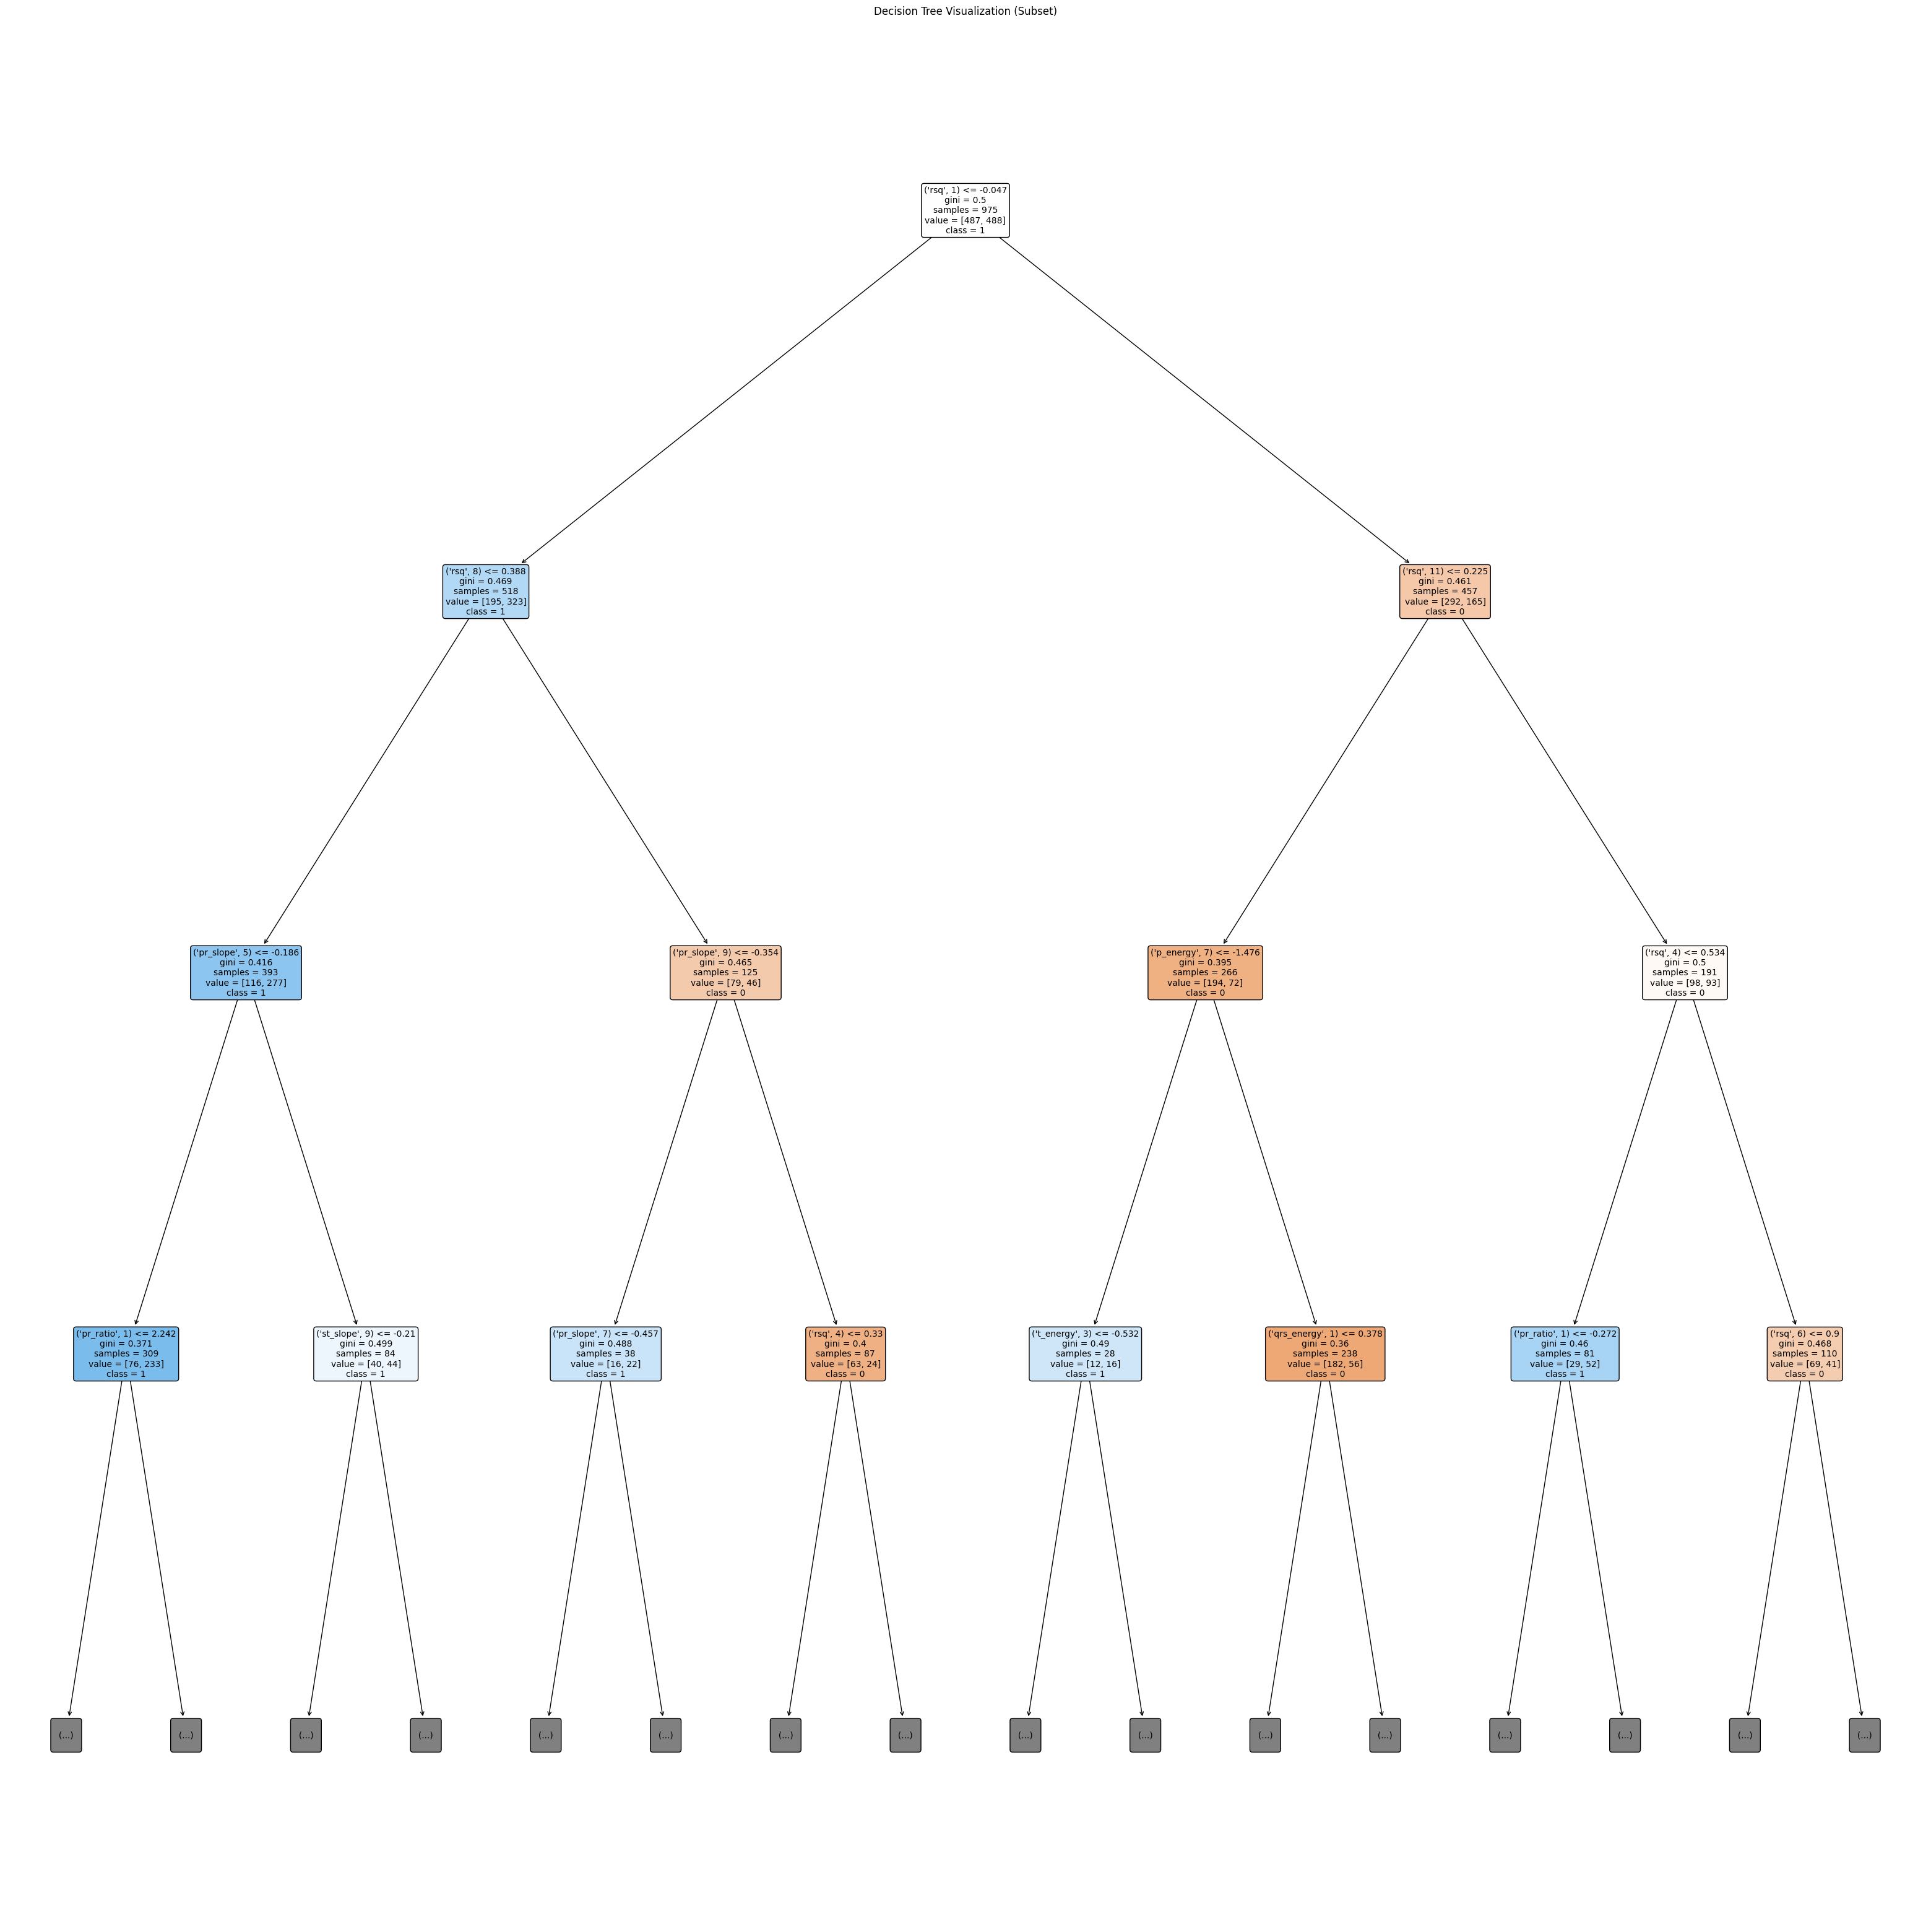

In [106]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt

# Visualize a smaller subtree with the first few levels
plt.figure(figsize=(40, 40))
plot_tree(decision_tree_model, filled=True, feature_names=X_train.columns, class_names=[str(i) for i in decision_tree_model.classes_], rounded=True, max_depth=3)
plt.title("Decision Tree Visualization (Subset)")
plt.show()

## Random Forest

In [107]:
rf_model = RandomForestClassifier()

k_fold = 5
cv_scores = cross_val_score(rf_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

rf_model.fit(X_train, y_train)

rf1_pred = rf_model.predict(X_test)

Cross-Validation Scores: [0.65641026 0.65641026 0.67692308 0.63076923 0.64102564]
Mean CV Accuracy: 0.6523


In [108]:
accuracy = accuracy_score(y_test, rf1_pred)
f1 = f1_score(y_test, rf1_pred)
precision = precision_score(y_test, rf1_pred)
recall = recall_score(y_test, rf1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6475409836065574
F1 Score: 0.5825242718446603
Precision: 0.6976744186046512
Recall: 0.5


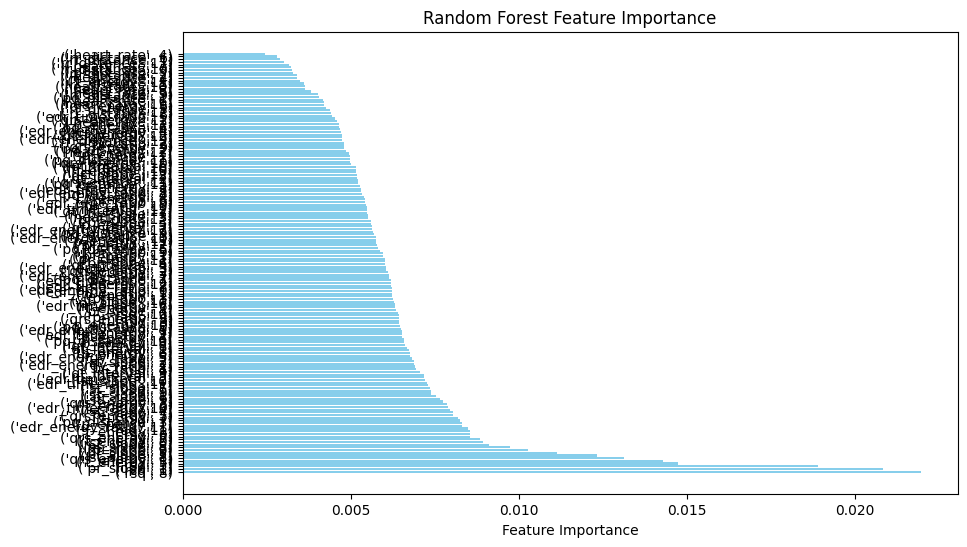

In [109]:
feature_importances = rf_model.feature_importances_

# Get feature importances
feature_importances = rf_model.feature_importances_

# Get feature names from X_train
feature_names = X_train.columns

# Create a DataFrame for better visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Convert 'Feature' column values to strings (if they are not already)
feature_importance_df['Feature'] = feature_importance_df['Feature'].astype(str)

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Create a horizontal bar plot
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance')
plt.show()

## Xgboost

In [110]:
xgboost_model = xgb.XGBClassifier(subsample=0.8, max_depth= 6, learning_rate= 0.2, colsample_bytree= 1.0)

k_fold = 5
cv_scores = cross_val_score(xgboost_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

xgboost_model.fit(X_train, y_train)

xgb1_pred = xgboost_model.predict(X_test)

Cross-Validation Scores: [0.60512821 0.68205128 0.63589744 0.61025641 0.65641026]
Mean CV Accuracy: 0.6379


In [111]:
accuracy = accuracy_score(y_test, xgb1_pred)
f1 = f1_score(y_test, xgb1_pred)
precision = precision_score(y_test, xgb1_pred)
recall = recall_score(y_test, xgb1_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.6680327868852459
F1 Score: 0.6493506493506493
Precision: 0.6756756756756757
Recall: 0.625


## SVM

In [112]:
svm_model = SVC()

k_fold = 5
cv_scores = cross_val_score(svm_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

Cross-Validation Scores: [0.63589744 0.67179487 0.67179487 0.66153846 0.61538462]
Mean CV Accuracy: 0.6513


In [113]:
print("Testing Performance")
accuracy = accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

# Print the results
print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Testing Performance
Accuracy: 0.6598360655737705
F1 Score: 0.6406926406926408
Precision: 0.6666666666666666
Recall: 0.6166666666666667


## Naive Bayes

In [114]:
naive_bayes_model = GaussianNB()

k_fold = 5
cv_scores = cross_val_score(naive_bayes_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

naive_bayes_model.fit(X_train, y_train)

# Make predictions
naive_bayes_pred = naive_bayes_model.predict(X_test)

# Calculate metrics
naive_bayes_accuracy = accuracy_score(y_test, naive_bayes_pred)
naive_bayes_f1 = f1_score(y_test, naive_bayes_pred)
naive_bayes_precision = precision_score(y_test, naive_bayes_pred)
naive_bayes_recall = recall_score(y_test, naive_bayes_pred)

# Print the results for Naive Bayes
print("Naive Bayes Accuracy:", naive_bayes_accuracy)
print("Naive Bayes F1 Score:", naive_bayes_f1)
print("Naive Bayes Precision:", naive_bayes_precision)
print("Naive Bayes Recall:", naive_bayes_recall)

Cross-Validation Scores: [0.56410256 0.58461538 0.55384615 0.62051282 0.61538462]
Mean CV Accuracy: 0.5877
Naive Bayes Accuracy: 0.5901639344262295
Naive Bayes F1 Score: 0.5614035087719299
Naive Bayes Precision: 0.5925925925925926
Naive Bayes Recall: 0.5333333333333333


## KNN

In [115]:
knn_model = KNeighborsClassifier()

k_fold = 5
cv_scores = cross_val_score(knn_model, X_train, y_train, cv=k_fold, scoring='accuracy')
print(f'Cross-Validation Scores: {cv_scores}')
print(f'Mean CV Accuracy: {cv_scores.mean():.4f}')

knn_model.fit(X_train, y_train)

# Make predictions
knn_pred = knn_model.predict(X_test)

# Calculate metrics
knn_accuracy = accuracy_score(y_test, knn_pred)
knn_f1 = f1_score(y_test, knn_pred)
knn_precision = precision_score(y_test, knn_pred)
knn_recall = recall_score(y_test, knn_pred)

# Print the results for K-nearest Neighbors
print("KNN Accuracy:", knn_accuracy)
print("KNN F1 Score:", knn_f1)
print("KNN Precision:", knn_precision)
print("KNN Recall:", knn_recall)

Cross-Validation Scores: [0.58461538 0.60512821 0.55897436 0.56410256 0.61025641]
Mean CV Accuracy: 0.5846
KNN Accuracy: 0.5614754098360656
KNN F1 Score: 0.5560165975103736
KNN Precision: 0.5537190082644629
KNN Recall: 0.5583333333333333
